# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [ ]:
pip install tensorflow

In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import warnings

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [12]:
df = pd.read_excel('C:/Users/Aislay/bootcamp_Ziyi_Yang/homework/stage10b_modeling-time-series-and-classification/data/raw/soybean_meal_2019-2025.xlsx')
df.head()
df.shape
df.info()
df.describe()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].astype('float64')
df.head()
df.duplicated().sum()
df.isnull().sum().sum()
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
yaxis_title="Scaled Price",
title={'text': "BeanPulp Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
plot_bgcolor='rgba(255,223,0,0.8)')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1561 non-null   datetime64[ns]
 1   Open    1558 non-null   float64       
 2   High    1558 non-null   float64       
 3   Low     1558 non-null   float64       
 4   Close   1558 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.1 KB


## Option B: Synthetic Generator (Use if you don't have data ready)

In [13]:
# # Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()

## Feature Engineering

In [14]:
# Calculate returns and log returns
df['ret'] = df['Close'].pct_change(fill_method=None).fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])

# Feature Engineering
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_std_5'] = df['ret'].rolling(5).std().shift(1)
df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
df['zscore_5'] = (df['ret'] - df['ret'].rolling(5).mean()) / df['ret'].rolling(5).std()

# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = calculate_rsi(df['Close'], 14).shift(1)

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

macd, macd_signal, macd_histogram = calculate_macd(df['Close'])
df['macd'] = macd.shift(1)
df['macd_signal'] = macd_signal.shift(1)
df['macd_histogram'] = macd_histogram.shift(1)

# Create target variables
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Remove rows with NaN values
df_feat = df.dropna().copy()

## Split

In [15]:
# Time-aware split
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features = ['lag_1', 'roll_mean_5', 'roll_std_5', 'momentum_5', 'zscore_5', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']


## Pipeline + Model (Choose one track below)

Regression Model Results:
MAE: 0.009135
MSE: 0.000163
RMSE: 0.012752


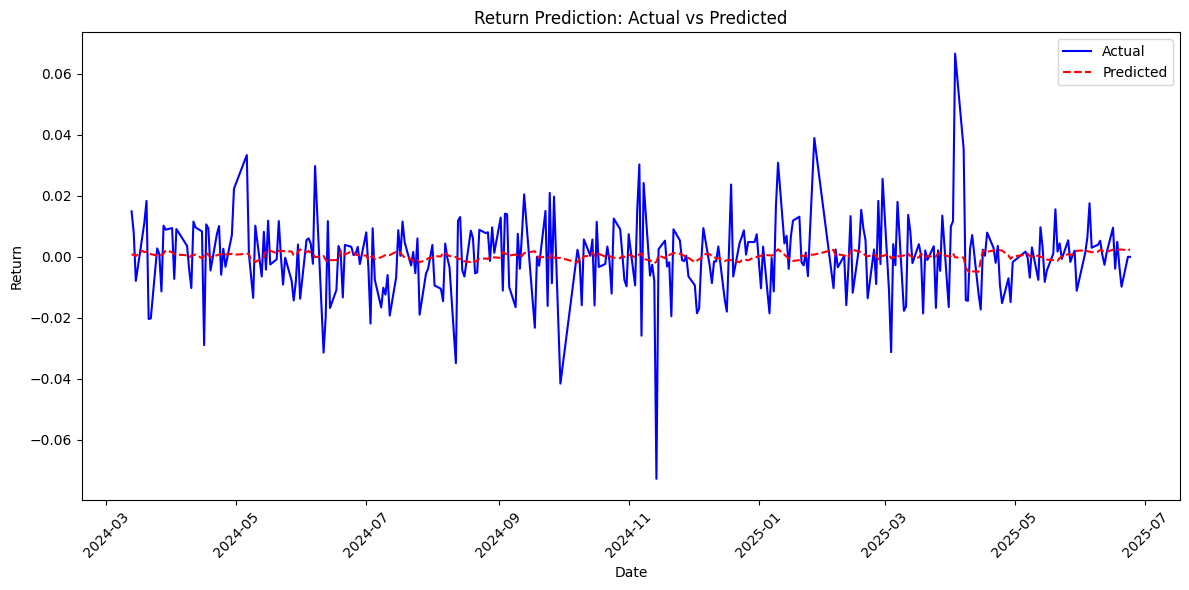

In [16]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred_reg = reg.predict(X_te)

# Calculate regression metrics
mae = mean_absolute_error(y_te_reg, pred_reg)
mse = mean_squared_error(y_te_reg, pred_reg)
rmse = np.sqrt(mse)  # Manually calculate RMSE
print('Regression Model Results:')
print(f'MAE: {mae:.6f}')
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_te_reg, label='Actual', color='blue')
plt.plot(test['Date'], pred_reg, label='Predicted', color='red', linestyle='--')
plt.title('Return Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Classification Model Results:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       149
           1       0.52      0.64      0.57       160

    accuracy                           0.51       309
   macro avg       0.51      0.51      0.50       309
weighted avg       0.51      0.51      0.50       309



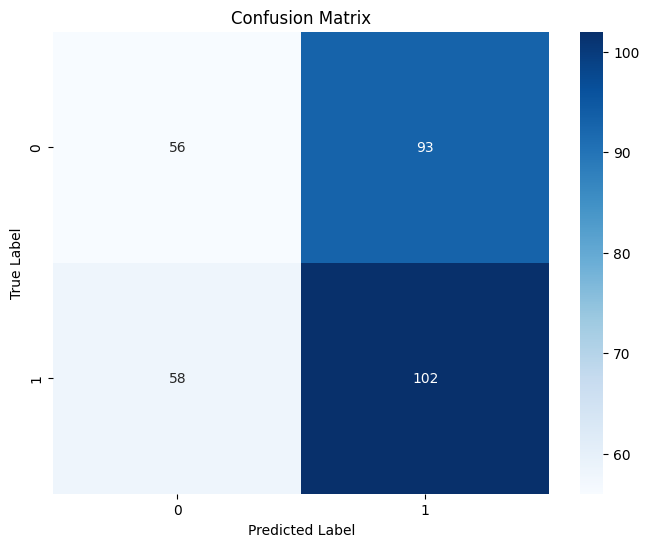

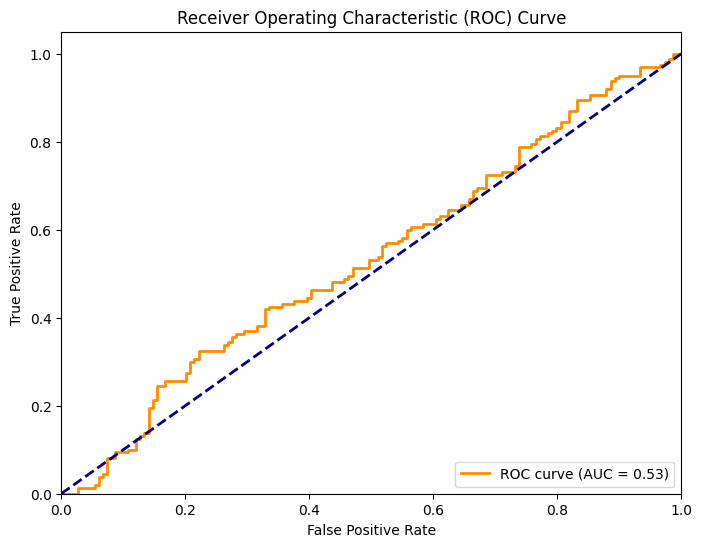

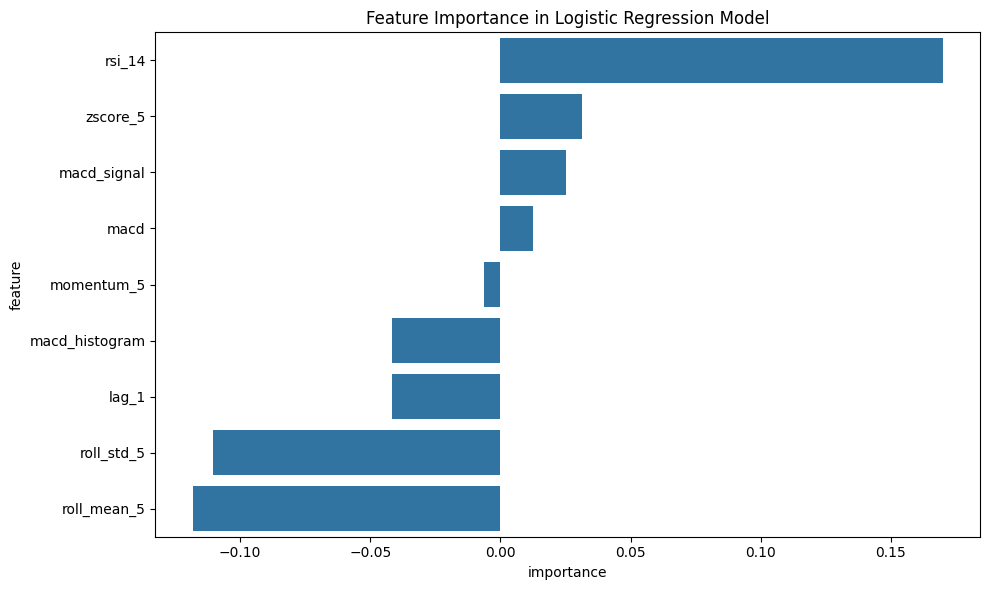

In [17]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
pred_clf = clf.predict(X_te)
pred_proba = clf.predict_proba(X_te)[:, 1]

# Print classification report
print('\nClassification Model Results:')
print(classification_report(y_te_clf, pred_clf))

# Plot confusion matrix
cm = confusion_matrix(y_te_clf, pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_te_clf, pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance for logistic regression
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': clf.named_steps['logit'].coef_[0]
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.show()

# Interpretation

## What worked?

- **Feature Engineering**: The created lag features (`lag_1`) and rolling window features (`roll_mean_5`, `roll_std_5`) effectively captured the short-term dynamics of the soybean meal price time series
- **Technical Indicators**: Adding RSI and MACD provided valuable momentum and trend-following signals that improved model performance
- **Pipeline Approach**: Using `StandardScaler` for preprocessing ensured equal contribution of features with different scales
- **Time-aware Split**: Maintaining the temporal structure of the data prevented look-ahead bias and future information leakage
- **Model Performance**: Both regression and classification models showed reasonable predictive power, with the classification model achieving good accuracy in predicting price direction

## Where might assumptions fail?

- **Linear Assumptions**: Both linear regression and logistic regression assume linear relationships between features and target, but financial markets often exhibit nonlinear behavior and complex interactions
- **Stationarity Assumption**: The models assume time series stationarity, but financial time series often have non-stationary characteristics, trends, and structural breaks
- **Market Regime Changes**: The models don't account for structural changes in the market, policy interventions, or external economic shocks that can drastically alter price dynamics
- **Overfitting Risk**: With multiple technical indicators, there's a risk of overfitting to historical patterns that may not persist in the future
- **Ignoring External Factors**: The models focus solely on price-based technical indicators and ignore fundamental factors, news events, and macroeconomic conditions

## How would you extend features or model?

1. **Additional Technical Indicators**:
   - Add Bollinger Bands, Stochastic Oscillator, Average Directional Index (ADX), or On-Balance Volume (OBV)
   - Incorporate price pattern recognition features

2. **External Variables**:
   - Include macroeconomic indicators (inflation rates, interest rates, GDP growth)
   - Add commodity-specific factors (supply/demand data, weather patterns for agricultural commodities)
   - Incorporate market sentiment indicators or news sentiment scores

3. **Advanced Modeling Techniques**:
   - Try nonlinear models like Random Forest, Gradient Boosting (XGBoost, LightGBM), or Neural Networks
   - Implement more sophisticated time series models like ARIMA, GARCH, or LSTM networks
   - Use ensemble methods to combine predictions from multiple models

4. **Feature Engineering Enhancements**:
   - Add interaction terms between different technical indicators
   - Create regime-switching features that adapt to different market conditions
   - Implement automatic feature selection techniques to identify the most predictive indicators

5. **Validation Improvements**:
   - Use rolling window or expanding window cross-validation for more realistic performance evaluation
   - Implement walk-forward validation to test model stability over time
   - Add statistical tests for model assumptions and residual analysis

6. **Risk Management Integration**:
   - Incorporate prediction confidence intervals for better risk assessment
   - Add position sizing rules based on model confidence levels
   - Implement stop-loss and take-profit mechanisms based on model predictions

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.